In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import h5py
import numpy as np

from vit_pytorch import ViT

sys.path.append("/home/lord225/pyrepos/explain-rl")

from ppo import PPO
import procgenwrapper


MODEL_PATH = "/home/lord225/pyrepos/explain-rl/preserve"
DATA_PATH = "/home/lord225/pyrepos/explain-rl/explain/records"

MODEL_NAME = "20250319-212023-ParentKnowShake_29_v3.1"

MODEL_PATH = os.path.join(MODEL_PATH, MODEL_NAME)
DATA_PATH = os.path.join(DATA_PATH, MODEL_NAME+"_replay.h5")


venv = procgenwrapper.ProcGenWrapper("starpilot", human=False, collect_seg=True)


model = PPO.load(MODEL_PATH, 
                 env=venv, 
                 print_system_info=True,
                 custom_objects={
                     "ViT":ViT,
                 })

# f.create_dataset("observations", data=np.array(observations, dtype=np.uint8))
# f.create_dataset("actions", data=np.array(actions))
# f.create_dataset("rewards", data=np.array(rewards))
# f.create_dataset("dones", data=np.array(dones))
# f.create_dataset("seg_observations", data=np.array(seg_observations, dtype=np.uint8))
# f.create_dataset("next_observations", data=np.array(next_observations, dtype=np.uint8))

dataset = h5py.File(DATA_PATH, "r")

observations = np.array(dataset["observations"])
actions = np.array(dataset["actions"])
rewards = np.array(dataset["rewards"])
dones = np.array(dataset["dones"])
seg_observations = np.array(dataset["seg_observations"])
next_observations = np.array(dataset["next_observations"])

dataset.close() 

print(observations.shape)

2025-03-21 22:11:04.718966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 22:11:04.719013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 22:11:04.719903: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 22:11:04.724013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-21 22:11:05.351002: W tensorflow/compiler/tf2

building procgen...done
== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
(10000, 64, 64, 9)


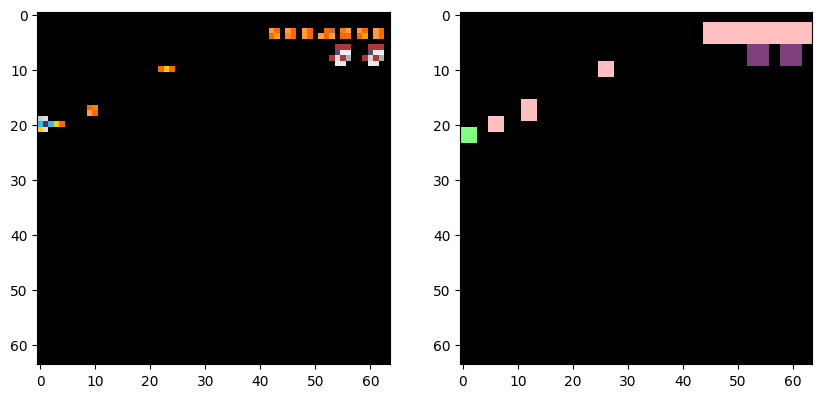

In [2]:
import matplotlib.pyplot as plt

def get_img(obs):
    return obs[:, :, 6:9]

ax, fig = plt.subplots(1, 2, figsize=(10, 5))

fig[0].imshow(get_img(observations[120]))
fig[1].imshow(seg_observations[120])

plt.show()

In [3]:
import imageio
import tqdm

def create_gif(observations, seg_observations, filename='segments.gif', duration=0.1):
    frames = []
    for i in tqdm.tqdm(range(len(observations))):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(get_img(observations[i]))
        ax[1].imshow(seg_observations[i])
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
    
    # Save the frames as a gif
    imageio.mimsave(filename, frames, duration=duration)

filename = "segments.gif"
if not os.path.exists(filename):
    create_gif(observations[:300], seg_observations[:300], filename=filename, duration=0.1)

In [4]:
net = model.policy

net

CustomActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): CustomNetwork(
    (policy_net): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(9, 64, 64))
      (1): ViT(
        (to_patch_embedding): Sequential(
          (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
          (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
          (2): Linear(in_features=144, out_features=64, bias=True)
          (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (transformer): Transformer(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (layers): ModuleList(
            (0-3): 4 x Mod

In [5]:
# Reshape the observations to match the expected input shape
obs_tensor = th.tensor(observations[:1].reshape((1, -1)), dtype=th.float32, device=net.device)

# Pass the tensor through the action_net
features_a, features_b = net.mlp_extractor(obs_tensor)

print(features_a.shape, features_b.shape)

torch.Size([1, 64]) torch.Size([1, 64])


In [6]:
# Get the action logits
action_logits = net.action_net(features_a)

print(action_logits.shape)

torch.Size([1, 15])


In [7]:
vit = net.mlp_extractor.policy_net
vit

Sequential(
  (0): Unflatten(dim=1, unflattened_size=(9, 64, 64))
  (1): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
      (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=144, out_features=64, bias=True)
      (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-3): 4 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=64, out_features=768, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=256, out_features=64, bias=True)
              (1): Dropout(p=0.1, inpl

In [8]:
observations[:1].shape

(1, 64, 64, 9)

In [9]:
vit = net.mlp_extractor.policy_net[1]
action_net = net.action_net

vit(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cuda())

tensor([[-2.8350e+00, -1.9895e-01,  1.7244e-01, -9.2211e-01, -3.0417e+00,
         -3.0340e-01,  4.5765e-01, -4.9784e-01,  6.8016e+00,  6.4393e-03,
         -3.2874e-02,  5.3977e-01,  5.8356e-01,  6.0408e-01,  1.4011e-01,
          1.4591e+00, -1.5015e+00, -4.9958e-01,  4.1861e+00, -4.3988e+00,
         -6.0399e-01, -1.3745e-01, -8.9160e-02,  3.5081e-01,  3.9511e-01,
         -3.3357e-01,  2.9650e+00,  6.5057e-01,  1.8595e+00,  9.8414e-02,
          9.1069e-01, -2.3756e+00, -3.8226e-01, -2.4187e-01,  1.6002e+00,
          6.1816e-01,  4.3644e-02, -1.1049e-02,  1.1443e-01,  4.1609e-01,
         -2.3137e-01, -4.0874e-01,  2.1452e-02,  3.6123e+00, -1.0593e+00,
         -1.1845e+00, -1.4683e+00, -1.1207e-01, -3.4588e-01, -1.0195e-01,
          3.6740e-01,  6.4817e+00,  6.8737e-02,  1.8213e+00,  1.4631e-01,
         -4.5314e-01, -3.6951e-01, -1.0969e+00, -2.6180e-02,  9.5235e-02,
          4.3290e-01,  5.6527e-01,  2.2981e+00,  3.7788e-01]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [10]:
vrobas = action_net(vit(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cuda()))

In [11]:
from vit_pytorch.extractor import Extractor
from vit_pytorch.recorder import Recorder

extractor = Extractor(vit)
recorder = Recorder(vit)


# Emdedding

In [12]:
probas, extracted = extractor(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cuda())

probas.shape, extracted.shape

(torch.Size([1, 64]), torch.Size([1, 257, 64]))

# Attention

In [13]:
probas, attention = recorder(th.tensor(observations[:1]).permute(0, 3, 1, 2).float().cuda())

probas.shape, attention.shape

(torch.Size([1, 64]), torch.Size([1, 4, 4, 257, 257]))

In [14]:
import cv2
def attention_map(attention, image):
    # avg attention over heads
    attention = np.array(attention).mean(axis=1)

    grid_size = int(np.sqrt(attention.shape[-1] - 1))
    num_layers = attention.shape[0]
    num_heads = attention.shape[1]
    reshaped = attention.reshape(
        (num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = mask / mask.max()
    return mask

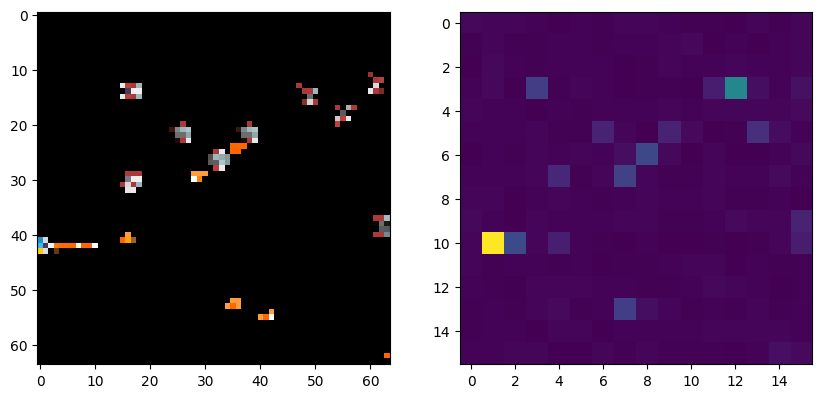

In [15]:
recorder = recorder.cuda()
frame = 304

obs = th.tensor(observations[frame]).reshape(-1, 64, 64, 9).permute(0, 3, 1, 2).float().cuda()

probas, attention = recorder(obs)

map = attention_map(attention.cpu().detach().numpy(), observations[frame])

# plot both
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(get_img(observations[frame]))
ax[1].imshow(map)

plt.show()

In [16]:
def generate_attention_gif(observations, filename='attention.gif', duration=0.1):
    frames = []
    for i in tqdm.tqdm(range(len(observations))):
        obs = th.tensor(observations[i]).reshape(-1, 64, 64, 9).permute(0, 3, 1, 2).float().cuda()
        probas, attention = recorder(obs)
        map = attention_map(attention.cpu().detach().numpy(), observations[i])
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(get_img(observations[i]))
        ax[1].imshow(map)
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
    
    # Save the frames as a gif
    imageio.mimsave(filename, frames, duration=duration)

filename = "attention.gif"
if not os.path.exists(filename):
    generate_attention_gif(observations[:300], filename=filename)

In [17]:
th.cuda.empty_cache()

# # calculate attention and extract features for all observations
# batch_size = 1
# attention_list = []

# recorder = recorder.cpu()

# for i in tqdm.tqdm(range(0, len(observations), batch_size)):
#     batch = th.tensor(observations[i:i+batch_size], device="cpu").permute(0, 3, 1, 2).float().cpu()
#     probas, attention = recorder(batch)
#     map = attention_map(attention.cpu().detach().numpy(), observations[i])
#     attention_list.append(map)

#     del batch
#     del probas
#     del attention
    
# attention_list = np.array(attention_list)

In [18]:
seg_observations.shape

(10000, 64, 64, 3)

In [19]:
UNIQUE_COLORS = np.array([(191, 255, 191), (191, 63, 191), (191, 255, 255), (127, 127, 255), (255, 127, 63), (0.0, 0.0, 0.0), (255, 191, 191), (255, 127, 127), (255, 191, 255), (127, 255, 127), (127, 63, 127), (63, 127, 127), (127, 63, 191), (127, 191, 63)], dtype=np.uint8)[np.newaxis]

seg_observations_index = np.argmax((seg_observations.reshape(-1, 1, 3) == UNIQUE_COLORS).all(axis=2), axis=1).reshape(seg_observations.shape[0], 64, 64, 1).astype(np.uint8)
seg_observations_index.shape

(10000, 64, 64, 1)

In [20]:
# calculate features using extractor
extractor = extractor.cpu()
batch_size = 1
features_list = []

for i in tqdm.tqdm(range(0, 5000, batch_size)):
    batch = th.tensor(observations[i:i+batch_size], device="cpu").permute(0, 3, 1, 2).float().cpu()
    probs, features = extractor(batch)
    features_list.append(features.detach().numpy())

    del batch
    del features

features_list = np.array(features_list).squeeze()

features_list.shape

100%|██████████| 5000/5000 [00:36<00:00, 135.30it/s]


(5000, 257, 64)

In [21]:
# (N, 257, 64) -> (N, 16, 16, 64) and cls token removed
features_list = features_list[:, 1:].reshape(-1, 16, 16, 64)

features_list.shape

(5000, 16, 16, 64)

In [22]:
# features are (1000, 16, 16, 64), but we can flatten them to (1000*16*16, 64)
features_list = features_list.reshape(-1, 64)
features_list.shape

(1280000, 64)

In [23]:
features_list[0]

array([-0.4738745 , -0.20058472,  0.8311043 ,  0.5513723 ,  0.50000894,
        0.00717555, -0.6626035 , -0.01276149,  0.2551518 ,  0.39480212,
       -0.2944417 ,  0.6838963 , -0.6595594 ,  1.1040663 , -0.6497473 ,
        0.7901266 ,  0.64749956,  0.9206247 , -0.3550242 , -0.4075674 ,
       -0.9387374 , -0.07284127, -0.41263017,  0.63401604, -0.10384065,
       -0.67258203,  0.5613997 ,  0.16093822, -0.47632784, -0.6602556 ,
        0.40970707,  0.29765743,  0.73276496, -0.53558433,  0.7056566 ,
       -0.3640565 ,  1.0255063 ,  0.649955  , -0.37258175, -0.91615987,
       -0.48446053,  0.7714949 ,  0.2327197 , -1.1184437 , -0.8579503 ,
       -0.14575054, -0.18371281, -0.04550555, -1.4970686 ,  0.82233477,
        0.06348649,  0.8468873 , -0.43891922,  0.94991577,  0.02997338,
        0.5523753 , -0.37700498, -0.8231679 ,  0.4745638 ,  0.654038  ,
        0.8706145 ,  0.20239985, -0.5590826 , -0.49236885], dtype=float32)

In [24]:
seg_observations_index.shape

(10000, 64, 64, 1)

In [25]:
# seg_observations_onehot
# (1000, 64, 64, 14) -> (1000, 16, 16, 14) -> (1000*16*16, 14)

# downsample to 16x16 using torch vision
import torch.nn.functional as F

print(seg_observations_index[0][0][0])

seg_observations_index_downsample = th.tensor(seg_observations_index)
print(seg_observations_index_downsample.shape)
# resample to 16x16 using torch vision
seg_observations_index_downsample = F.interpolate(seg_observations_index_downsample.permute(0, 3, 1, 2).float(), size=(16, 16), mode="nearest").int()

print(seg_observations_index_downsample[0][0][0])

seg_observations_onehot = seg_observations_index_downsample.reshape(-1, 1)
seg_observations_onehot.shape

[5]
torch.Size([10000, 64, 64, 1])
tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=torch.int32)


torch.Size([2560000, 1])

In [26]:
seg_observations_index_downsample.shape

torch.Size([10000, 1, 16, 16])

In [27]:
features_list.shape, seg_observations_onehot.shape

((1280000, 64), torch.Size([2560000, 1]))

In [ ]:
# (1000, 16, 16, 64)

from zmq import device


data_extractor = nn.Sequential(
    nn.Linear(64, 14),
    nn.Softmax(dim=1)
)

X = th.tensor(features_list, dtype=th.float32)
y = th.tensor(seg_observations_onehot[:16*16*5000], dtype=th.float32)
print(X.shape, y.shape)
# remove from dataset value 5
mask = y != 5
X_masked = X[mask.squeeze()]
y_masked = y[mask.squeeze()]


print(X.shape, y.shape)

# train the data extractor to predict the segment from the features
dataset_features = th.utils.data.TensorDataset(X_masked, y_masked)

train_loader = th.utils.data.DataLoader(dataset_features, batch_size=512, shuffle=True, num_workers=4) 

optimizer = th.optim.Adam(data_extractor.parameters(), lr=1e-3)

epoches = tqdm.tqdm(range(30))
for epoch in epoches:
    losses = []
    for features, target in train_loader:
        optimizer.zero_grad()
        output = data_extractor(features)
        # target is int,
        loss = F.cross_entropy(output, target.squeeze().long())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    epoches.set_description(f"Epoch {epoch} Loss: {np.mean(losses)}")

    if epoch > 10:
        optimizer.param_groups[0]["lr"] = 1e-4
    if epoch > 15:
        optimizer.param_groups[0]["lr"] = 1e-5
    if epoch > 20:
        optimizer.param_groups[0]["lr"] = 1e-6

/tmp/ipykernel_62505/428067796.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = th.tensor(seg_observations_onehot[:16*16*5000], dtype=th.float32)


torch.Size([1280000, 64]) torch.Size([1280000, 1])
torch.Size([1280000, 64]) torch.Size([1280000, 1])


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 29 Loss: 2.1722982379625426: 100%|██████████| 30/30 [00:39<00:00,  1.31s/it]


In [38]:
X.shape

torch.Size([1280000, 64])

In [39]:
# try visualizing the output
output = data_extractor(X)
print(output.shape)
output = output.reshape(-1, 16, 16, 14)
output.shape

torch.Size([1280000, 14])


torch.Size([5000, 16, 16, 14])

In [40]:
output[200][5][5]

tensor([2.2364e-06, 1.5850e-06, 2.6735e-06, 1.3694e-06, 1.2194e-06, 2.2088e-06,
        9.9996e-01, 1.0140e-06, 2.5329e-06, 3.3779e-06, 2.0310e-05, 1.7662e-06,
        2.3356e-06, 2.1944e-06], grad_fn=<SelectBackward0>)

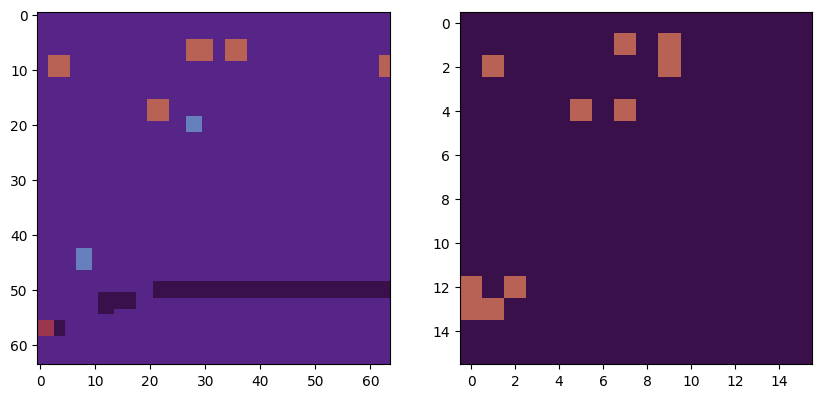

In [41]:
# display
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

I = 200
ax[0].imshow(seg_observations_index[I].squeeze(), cmap="twilight", vmin=0, vmax=13)
ax[1].imshow(output[I].detach().numpy().argmax(axis=2), cmap="twilight", vmin=0, vmax=13)

In [42]:
# make animation out of seg_observations_index and output

def create_segmentation_gif(observations, segmentations, filename='segmentations_first.gif', duration=0.1):
    frames = []
    for i in tqdm.tqdm(range(len(observations))):
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(get_img(observations[i]))
        ax[1].imshow(segmentations[i].argmax(axis=2), cmap="twilight", vmin=0, vmax=13)
        plt.close(fig)
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(image)
    
    # Save the frames as a gif
    imageio.mimsave(filename, frames, duration=duration)

filename = "segmentations_first.gif"
if not os.path.exists(filename):
    create_segmentation_gif(observations[:300], output.detach().numpy(), filename=filename)

100%|██████████| 300/300 [00:23<00:00, 12.71it/s]
